In [1]:
#SQUARE LATTICE APPROACH 2

In [309]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

In [310]:
class ProductRNN1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN1, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        # Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        # print(x.shape)
        # print(bj.shape)
        x_0=torch.cat((bj.view(-1,1,1),x[:,0:-1,:]), dim=1)
        # print(x_0)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x)
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        return sum_result

    def generate_lattice(self, bj, n_iterations, switch):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out.shape)
                # print(h0.shape)
                out = self.fc(out)
                # print(out.shape)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out[:, -1, :].shape)
                # Sample from the output probabilities
                # print(out[:, -1, :])


                
                # array=out[:,-1,:]
                # # print(array)
                # # array[3]=torch.tensor([0.1,0.9])
                # condi=(array[:, 0] > array[:, 1]).float().view(-1,1)
                # # print(array,torch.concatenate((condi,1-condi),dim=1))
                # # max_values, _ = array.max(dim=1, keepdim=True)
                # # print(max_values)
                # modified_array = (torch.concatenate((condi,1-condi),dim=1)*switch+1)*array
                # # modified_array = torch.where(array[:, 0] > array[:, 1], torch.tensor([1, 10]), torch.tensor([10, 1]))
                # # print(modified_array)
                # sampled_index = torch.multinomial(modified_array, 1)
                         
                # sampled_index = torch.multinomial(out[:, -1, :], 1)
                # print(out[:, -1, :])
                if switch==0:
                    sampled_index = torch.randint(2, (x.size(0),1))
                else:
                    sampled_index = torch.multinomial(out[:, -1, :], 1)
                
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))

In [311]:
N = 6

In [313]:
def bc(i):
    if i > N-1:
        return 0
    if i < 0:
        return N-1
    else:
        return i

def energy_nm(lattice, n, m):
    return -1 * lattice[n,m] * (lattice[bc(n-1), m] + lattice[bc(n+1), m] + lattice[n, bc(m-1)] + lattice[n, bc(m+1)])

def Energy(lattice):
    Energy_=[]
    for i in range(lattice.size(0)):
        energy=0
        for j in range(0,N):
            for k in range(0,N):
                energy+=energy_nm(lattice[i],j,k)
        Energy_.append(energy)
    return np.array(Energy_)/2

In [314]:
T= np.concatenate((np.arange(0.01,1,0.05),np.arange(1,10,0.6)))
T

array([0.01, 0.06, 0.11, 0.16, 0.21, 0.26, 0.31, 0.36, 0.41, 0.46, 0.51,
       0.56, 0.61, 0.66, 0.71, 0.76, 0.81, 0.86, 0.91, 0.96, 1.  , 1.6 ,
       2.2 , 2.8 , 3.4 , 4.  , 4.6 , 5.2 , 5.8 , 6.4 , 7.  , 7.6 , 8.2 ,
       8.8 , 9.4 ])

In [315]:
T= np.arange(0.01,10,0.6)
# T=np.array([0.01,0.1,0.3,0.6,0.8,1,2,2.2,2.4,2.7,3,5,6,7])
BJs=1/T
# BJs = np.arange(0.1, 2, 0.1)


input_size=1
hidden_size=70
num_layers=2

models = []
for _ in range(len(BJs)):
    model = ProductRNN1(input_size, hidden_size, num_layers)
    models.append(model)

optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

In [316]:
Loss=[[] for i in range(len(BJs))]

In [317]:
ln_q=[[] for i in range(len(BJs))]
eneg=[[] for i in range(len(BJs))]

In [318]:
Batch_size=64

In [336]:
# train
num_epochs = 50
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    if os.path.exists(os.path.join(os.getcwd(),'stop_true.txt')):
        print('a')
        break
    for i in range(0,len(BJs)):#[len(BJs)-1]:#range(1):#len(BJs)):
        optimizers[i].zero_grad()
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size))
        # print(BJs_batch.shape)
        Lattice_batch=torch.tensor(models[i].generate_lattice(torch.zeros((Batch_size)),N**2,1)).type(torch.float32)
        # print(Lattice_batch[1,:,:])
        Energy_batch=torch.tensor(Energy(Lattice_batch)).view(-1,1)
        # print(Energy_batch[1])
        # print(Lattice_batch.shape,Lattice_batch.size(0))
        # print(Energy_batch)
        Log_q_batch=models[i](torch.zeros((Batch_size)),Lattice_batch)
        # print(Log_q_batch)
        # print(Energy_batch*BJs_batch.view(-1,1)[0])
        # print(Log_q_batch.shape, Energy_batch.shape, BJs_batch.shape, BJs_batch.view(-1,1).shape)
        # print(Energy_batch)
        # loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2
        loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2
        # loss_batch=-Log_q_batch
        # print(Log_q_batch)
        # print(Energy_batch)
        # print(torch.sign(Energy_batch*BJs_batch.view(-1,1)+ Log_q_batch))
        # loss_batch=(2*Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2))
        # loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)
        # loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)*torch.exp(Log_q_batch)


        # condition=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)<0
        # for o in condition:
        #     if o==False:
        #         print('---')
        # positive_loss=-(Log_q_batch + (torch.log(-(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch))))
        # negative_loss=(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
        # loss_batch = torch.where(condition, positive_loss, negative_loss)
        # print(positive_loss)
        # print(loss_batch)
        # print(-(Log_q_batch + (torch.log(-(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))))
        # # print(loss_batch)
        
        # print(loss_batch.shape)
        total_loss_batch=loss_batch.mean()/N**2
        Loss[i].append((loss_batch.mean()/N**2).item())
        ln_q[i]=np.concatenate((ln_q[i],Log_q_batch.view(-1).detach().numpy()))
        eneg[i]=np.concatenate((eneg[i],Energy_batch.view(-1).detach().numpy()))
        # kmds
        total_loss_batch.backward()
        optimizers[i].step()
        # print(Energy_batch)
        print(f'     Batch Loss Model {i}: {total_loss_batch.item()}')
    # dee

Epoch 1/50:
     Batch Loss Model 5: 21.798983514650708
     Batch Loss Model 7: 18.039460963388844
Epoch 2/50:
     Batch Loss Model 5: 21.844393106048106
     Batch Loss Model 7: 17.90592037478568
Epoch 3/50:
     Batch Loss Model 5: 21.345681400229974
     Batch Loss Model 7: 17.908457377552427
Epoch 4/50:
     Batch Loss Model 5: 21.880901778042887
     Batch Loss Model 7: 18.094145821629514
Epoch 5/50:
     Batch Loss Model 5: 21.67970257784878
     Batch Loss Model 7: 18.624596522608925
Epoch 6/50:
     Batch Loss Model 5: 21.597414210241823
     Batch Loss Model 7: 17.973511087618174
Epoch 7/50:
     Batch Loss Model 5: 21.203613396164464
     Batch Loss Model 7: 18.39275740331399
Epoch 8/50:
     Batch Loss Model 5: 21.736950645572172
     Batch Loss Model 7: 18.66138708731621
Epoch 9/50:
     Batch Loss Model 5: 21.30734611779898
     Batch Loss Model 7: 18.622471887162412
Epoch 10/50:
     Batch Loss Model 5: 21.20146408120705
     Batch Loss Model 7: 18.771524667909798
Epoch

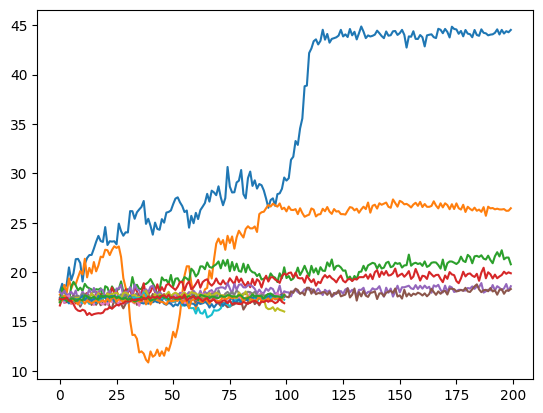

In [324]:
for i in range(1,len(BJs)):
    plt.plot(np.array(Loss[i]))

In [304]:
I=0

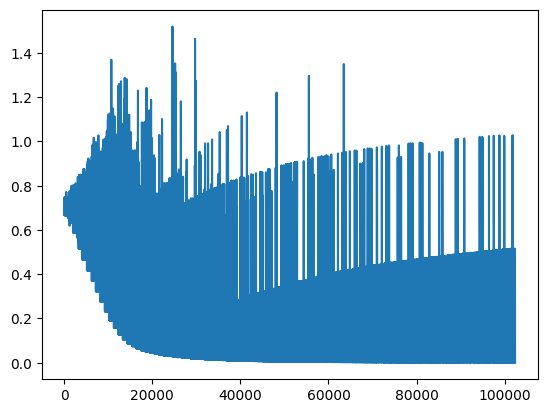

In [305]:
for i in [I]:#range(0,len(BJs)):
    plt.plot(-np.array(ln_q[i])/N**2)

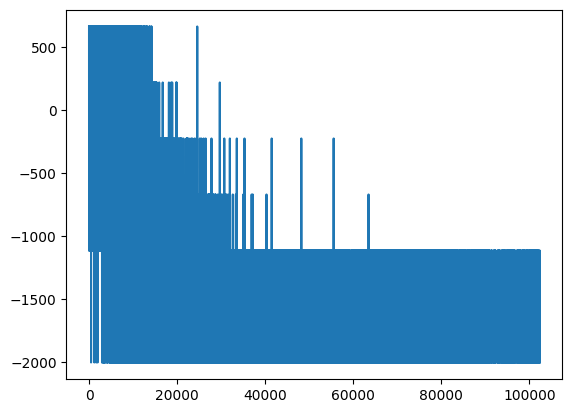

In [306]:
for i in [I]:#range(0,len(BJs)):
    plt.plot(np.array(eneg[i]*BJs[i])/N**2)

/tmp/ipykernel_366157/3441284514.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.array(-(ln_q[i] + np.log(-(eneg[i]*BJs[i] + ln_q[i]))))/N**2)


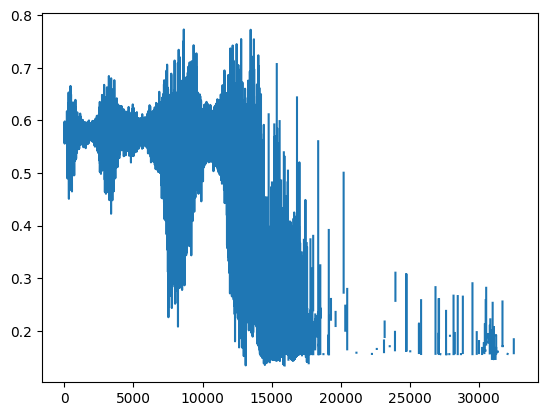

In [1489]:
for i in [I]:#range(0,len(BJs)):
    plt.plot(np.array(-(ln_q[i] + np.log(-(eneg[i]*BJs[i] + ln_q[i]))))/N**2)

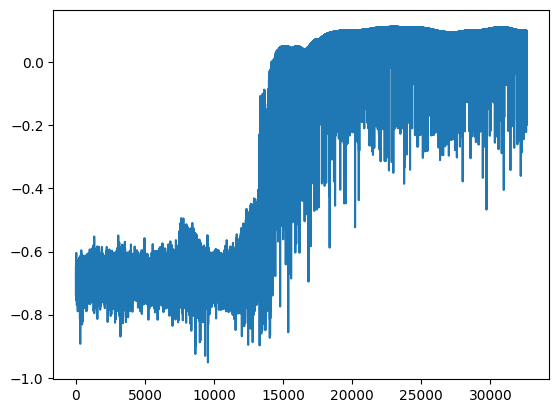

In [1488]:
for i in [I]:#range(0,len(BJs)):
    plt.plot(np.array((eneg[i]*BJs[i] + ln_q[i]))/N**2)

In [889]:
BJs

array([1.00000000e+03, 6.66222518e-01, 3.33222259e-01, 2.22172850e-01,
       1.66638894e-01, 1.33315558e-01, 1.11098767e-01])

In [869]:
T

array([1.000e-03, 1.501e+00, 3.001e+00, 4.501e+00, 6.001e+00, 7.501e+00,
       9.001e+00])

/tmp/ipykernel_13483/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

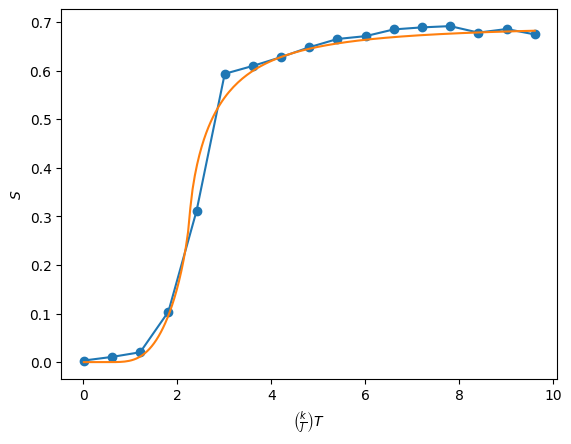

In [337]:
Batch_size_av=128
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size_av)).type(torch.float32)
        Lattice_batch=torch.tensor(models[i].generate_lattice(torch.zeros((Batch_size_av)),N**2,1)).type(torch.float32)
        # print(I)
        Log_q_batch=models[i](torch.zeros((Batch_size_av)),Lattice_batch)
        # print(Log_q_batch)
        S[i]=-torch.mean(Log_q_batch).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)

T_values = np.linspace(0.01, 1/BJs[-1], 200)
S_values_temp = [Entropy(T) for T in T_values]
plt.plot(T_values, S_values_temp)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

/tmp/ipykernel_13483/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

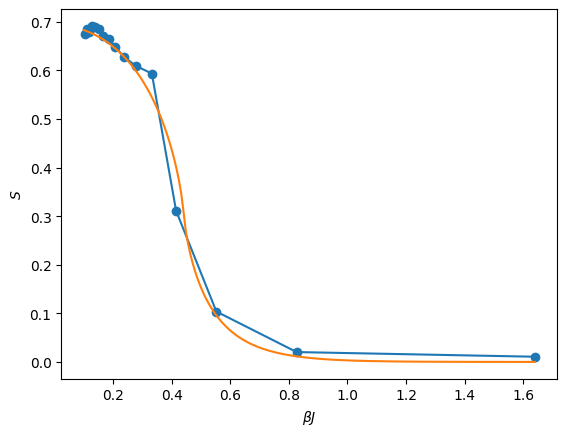

In [338]:
J=1
plt.plot(BJs[J:],S[J:])
plt.scatter(BJs[J:],S[J:])

Beta_values = np.linspace(0.1, BJs[J], 200)
S_values_beta = [Entropy(1/Beta) for Beta in Beta_values]
plt.plot(Beta_values, S_values_beta)
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [109]:
S

array([0.03686733, 0.37137138, 0.59368622, 0.66688324, 0.67885201,
       0.68431274, 0.68527748])

In [985]:
1/BJs

array([1.000e-03, 1.501e+00, 3.001e+00, 4.501e+00, 6.001e+00, 7.501e+00,
       9.001e+00])

In [339]:
# testing that sum of all lattice configs is equal to 1

class ProductRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(ProductRNN2, self).__init__()
        self.rnn = nn.RNN(input_size+1, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Output 2 numbers: one for each +1, -1

    def forward(self, bj, x):
        x = x.view(x.size(0), -1,1) # flatten + transpose
        # print(((x+1)/2).shape)
        # print(x[:,0:-1,:].shape)
        Zeros=torch.zeros(x.size(0), 1, 1)
        #bj.view(-1,1,1)
        # print(x[:,0:-1,:].shape,Zeros.shape)
        x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1).shape)
        x_0=torch.cat((x_0,bj.repeat(x_0.size(1)).view(-1,x_0.size(1),1)),dim=2)
        # print(x_0)
        # print(x_0)
        # x_0=torch.cat((Zeros,x[:,0:-1,:]), dim=1)
        # print(bj.view(-1,1,1).shape)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device) # (self.rnn.num_layers, x.size(0), self.rnn.hidden_size) for x=(batch_size, sequence_length, input_size); x.size(0)==batch_size
        # print(x_0[:,:,0].view(16,9,1).shape)
        # print(x_0[:,:,0].view(-1,4,1))
        out, _ = self.rnn(x_0, h0)
        # print(out.shape)
        out = self.fc(out) # for o/p of each time stamp, we have len(hidden_state) o/p. Feeding them to a linear layer and getting single output for each tiemstamp 
        # print(out.shape)
        out = F.log_softmax(out, dim=2) # normalizing o/p at each time stamp
        extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values.shape)
        sum_result = extracted_values.sum(dim=1)
        # print(sum_result.shape)
        # print(out)
        
        
        # out = F.softmax(out, dim=2) # normalizing o/p at each time stamp
        # print(out)
        # extracted_values = out.gather(dim=2, index=((x+1)/2).type(torch.int64))
        # print(extracted_values)
        # sum_result = torch.prod(extracted_values,dim=1)
        # print(sum_result.shape)
        return sum_result

    def generate_lattice(self, bj, n_iterations, switch):
        # bj is tensor(0.300) for example
        # Ensure bj is a tensor and has the correct shape
        x=bj.view(-1,1,1)
        Zeros=torch.zeros(x.size(0), 1, 1)
        # print(Zeros.shape,x.shape)
        x=torch.cat((Zeros,x), dim=2)
        # print(x)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(bj.device)
        # Initialize the generated lattice configuration
        generated_lattice = np.zeros((x.size(0),n_iterations))

        with torch.no_grad():
            for i in range(n_iterations):
                # print(x.shape)
                out, h0 = self.rnn(x, h0)
                # print(out)
                # print(h0)
                out = self.fc(out)
                out = F.softmax(out, dim=2)
                # print(out.shape)
                # print(out[:, -1, :].shape)
                # Sample from the output probabilities
                # print(out[:, -1, :])
                # sampled_index = torch.multinomial(out[:, -1, :], 1)

                if switch==0:
                    sampled_index = torch.randint(2, (64,1))
                else:
                    sampled_index = torch.multinomial(out[:, -1, :], 1)
                
                # print(sampled_index.shape)
                # print(sampled_index)
                # Map sampled index to -1 or +1
                x = (2 * sampled_index - 1).float()
    
                # Append the sampled value to the generated lattice
                generated_lattice[:,i]=x.view(-1)
                x=x.view(-1,1,1)
                x=torch.cat((x,bj.view(-1,1,1)), dim=2)
                # print(x)
    
        return generated_lattice.reshape(-1, int(np.sqrt(n_iterations)), int(np.sqrt(n_iterations)))


In [360]:
N = 6

In [361]:
Batch_size=64

T= np.arange(0.01,10,0.6)
BJs=1/T


input_size=1
hidden_size=70
num_layers=2


model = ProductRNN2(input_size, hidden_size, num_layers)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [362]:
Loss=[[] for i in range(len(BJs))]

In [372]:
# train V2.0
num_epochs = 80
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    for i in range(0,len(BJs)):#[len(BJs)-1]:#range(1):#len(BJs)):
        optimizer.zero_grad()
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size)).type(torch.float32)
        # print(BJs_batch.shape)
        Lattice_batch=torch.tensor(model.generate_lattice(BJs_batch,N**2,1)).type(torch.float32)
        Energy_batch=torch.tensor(Energy(Lattice_batch)).view(-1,1)
        # print(Lattice_batch.shape,Lattice_batch.size(0))
        # print(Energy_batch)
        Log_q_batch=model(BJs_batch,Lattice_batch)
        # print(Log_q_batch.shape, Energy_batch.shape, BJs_batch.shape, BJs_batch.view(-1,1).shape)
        # print(Energy_batch)
        loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2
        # print(Log_q_batch)
        # print(Energy_batch)
        # loss_batch=-(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2))
        # print(loss_batch.shape)

        # condition=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)<0
        # for o in condition:
        #     if o==False:
        #         print('---')
        # positive_loss=-(Log_q_batch + torch.log(-(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
        # negative_loss=(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)))
        # loss_batch = torch.where(condition, positive_loss, negative_loss)

        # print(Log_q_batch)
        # print((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch))
        
        total_loss_batch=loss_batch.mean()/N**2
        total_loss_batch.backward()
        optimizer.step()
        Loss[i].append(total_loss_batch.item())
        # print(Energy_batch)
        # kmds
        print(f'     Batch Loss Model {i}: {total_loss_batch.item()}')

Epoch 1/80:
     Batch Loss Model 0: 1440000.125
     Batch Loss Model 1: 386.6443176269531
     Batch Loss Model 2: 97.601318359375
     Batch Loss Model 3: 43.23823547363281
     Batch Loss Model 4: 26.28774070739746
     Batch Loss Model 5: 20.351593017578125
     Batch Loss Model 6: 18.205392837524414
     Batch Loss Model 7: 18.036285400390625
     Batch Loss Model 8: 17.106231689453125
     Batch Loss Model 9: 17.622953414916992
     Batch Loss Model 10: 17.09025001525879
     Batch Loss Model 11: 17.107723236083984
     Batch Loss Model 12: 16.511981964111328
     Batch Loss Model 13: 16.711362838745117
     Batch Loss Model 14: 16.38658905029297
     Batch Loss Model 15: 16.63324546813965
     Batch Loss Model 16: 16.13037109375
Epoch 2/80:
     Batch Loss Model 0: 1440000.125
     Batch Loss Model 1: 384.8365478515625
     Batch Loss Model 2: 93.49112701416016
     Batch Loss Model 3: 37.13468551635742
     Batch Loss Model 4: 24.100526809692383
     Batch Loss Model 5: 19.542

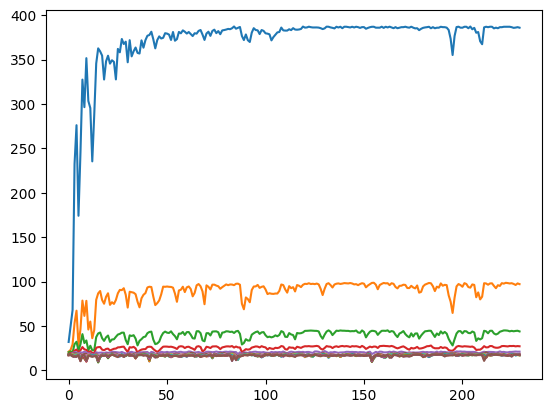

In [373]:
for i in range(1,len(BJs)):
    plt.plot(np.array(Loss[i]))

/tmp/ipykernel_13483/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

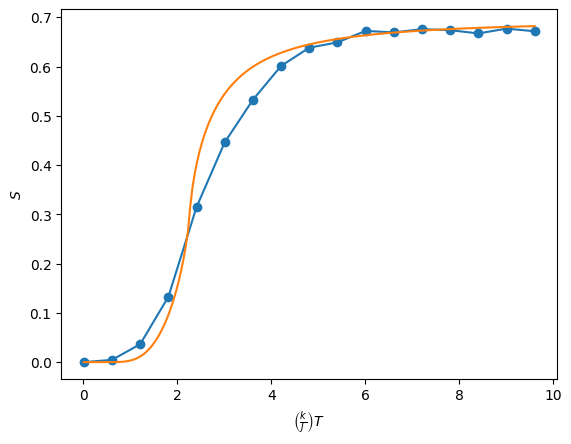

In [369]:
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size)).type(torch.float32)
        # print(BJs_batch)
        Lattice_batch=torch.tensor(model.generate_lattice(BJs_batch,N**2,1)).type(torch.float32)
        # print(I)
        Log_q_batch=model(BJs_batch,Lattice_batch)
        # print(torch.exp(Log_q_batch)*Log_q_batch)
        S[i]=-torch.mean(Log_q_batch).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.scatter(1/BJs,S)

T_values = np.linspace(0.01, 1/BJs[-1], 200)
S_values_temp = [Entropy(T) for T in T_values]
plt.plot(T_values, S_values_temp)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

/tmp/ipykernel_13483/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0, 0.5, '$S$')

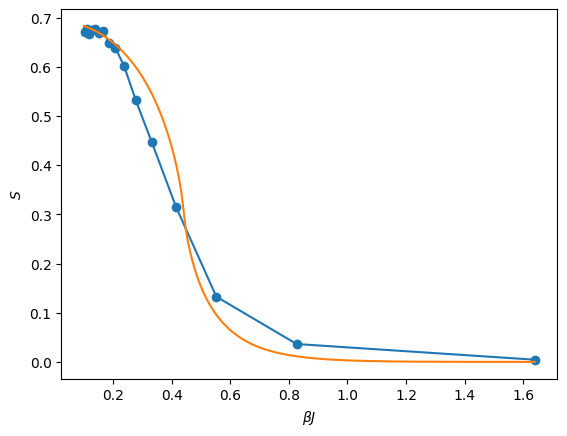

In [370]:
plt.plot(BJs[1:],S[1:])
plt.scatter(BJs[1:],S[1:])
Beta_values = np.linspace(0.1, BJs[J], 200)
S_values_beta = [Entropy(1/Beta) for Beta in Beta_values]
plt.plot(Beta_values, S_values_beta)
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [371]:
S

array([1.02022629e-05, 4.55993869e-03, 3.64139047e-02, 1.32576134e-01,
       3.14827760e-01, 4.46157296e-01, 5.32504453e-01, 6.01245350e-01,
       6.38214747e-01, 6.49046739e-01, 6.72400157e-01, 6.69195599e-01,
       6.75918155e-01, 6.73824522e-01, 6.67145040e-01, 6.76956283e-01,
       6.71534856e-01])

In [ ]:
# train
num_epochs = 100
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    for i in range(len(BJs)):#[len(BJs)-1]:#range(1):#len(BJs)):
        optimizers[i].zero_grad()
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size)).type(torch.float32)
        # print(BJs_batch.shape)
        Lattice_batch=torch.tensor(models[i].generate_lattice(BJs_batch,N**2)).type(torch.float32)
        Energy_batch=torch.tensor(Energy(Lattice_batch)).view(-1,1)
        # print(Lattice_batch.shape,Lattice_batch.size(0))
        # print(Energy_batch)
        Log_q_batch=models[i](BJs_batch,Lattice_batch)
        # print(Log_q_batch.shape, Energy_batch.shape, BJs_batch.shape, BJs_batch.view(-1,1).shape)
        # print(Energy_batch)
        loss_batch=(Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2
        # print(Log_q_batch)
        # print(Energy_batch)
        # loss_batch=-(Log_q_batch + torch.log((Energy_batch*BJs_batch.view(-1,1) + Log_q_batch)**2))
        # print(loss_batch.shape)
        total_loss_batch=loss_batch.mean()/N**2
        total_loss_batch.backward()
        optimizers[i].step()
        Loss[i].append(total_loss_batch.item())
        # print(Energy_batch)
        # kmds
        print(f'     Batch Loss Model {i}: {total_loss_batch.item()}')

In [ ]:
for i in range(len(BJs)):
    plt.plot(np.array(Loss[i]))

In [ ]:
S=np.zeros(len(BJs))
for i in range(len(BJs)):
    with torch.no_grad():
        BJs_batch=torch.tensor(np.repeat(BJs[i],Batch_size)).type(torch.float32)
        Lattice_batch=torch.tensor(model.generate_lattice(BJs_batch,N**2)).type(torch.float32)
        # print(I)
        Log_q_batch=model(BJs_batch,Lattice_batch)
        S[i]=-torch.mean(Log_q_batch).item()/N**2
        # print(len(I),I.shape)
        # S[i]=torch.sum(torch.mul(torch.exp(log__q),log__q)).item()
        # print(torch.sum(torch.mul(torch.exp(log__q),log__q)).item())
plt.plot(1/BJs,S)
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$S$')

In [ ]:
plt.plot(BJs,S)
plt.xlabel(r'$\beta J$')
plt.ylabel(r'$S$')

In [147]:
T

array([0.01, 0.61, 1.21, 1.81, 2.41, 3.01, 3.61, 4.21, 4.81, 5.41, 6.01,
       6.61, 7.21, 7.81, 8.41, 9.01, 9.61])

In [148]:
1/T

array([100.        ,   1.63934426,   0.82644628,   0.55248619,
         0.41493776,   0.33222591,   0.27700831,   0.23752969,
         0.20790021,   0.18484288,   0.16638935,   0.15128593,
         0.13869626,   0.12804097,   0.11890606,   0.11098779,
         0.10405827])

In [225]:
BJs

array([100.        ,   1.63934426,   0.82644628,   0.55248619,
         0.41493776,   0.33222591,   0.27700831,   0.23752969,
         0.20790021,   0.18484288,   0.16638935,   0.15128593,
         0.13869626,   0.12804097,   0.11890606,   0.11098779,
         0.10405827])

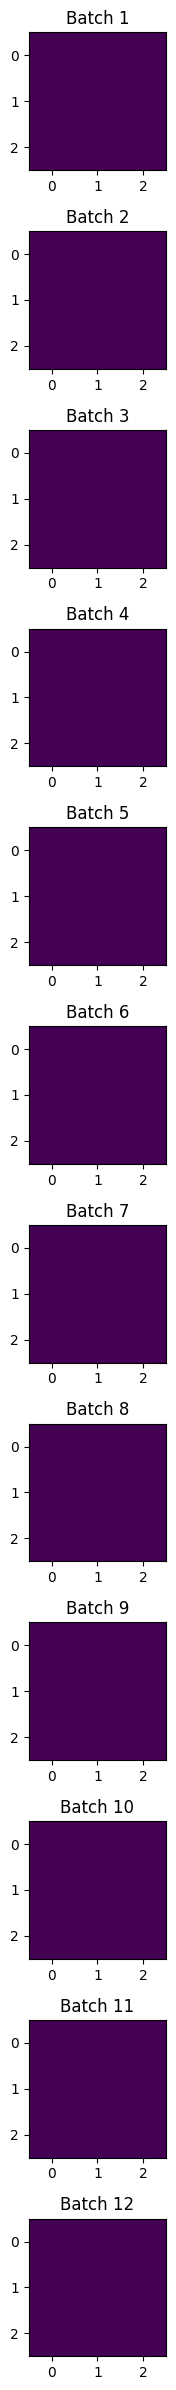

In [308]:
with torch.no_grad():
    I=0 # which model number
    BJs_batch=torch.tensor(np.repeat(BJs[I],Batch_size)).type(torch.float32) # CHANGE ME
    BJs_batch=BJs_batch[0:12]
    Lattice_batch=torch.tensor(models[I].generate_lattice(BJs_batch,N**2,1)).type(torch.float32)
    # plt.imshow(Lattice_batch[4])
    bbatch_size, rows, cols = Lattice_batch.shape
    fig, axs = plt.subplots(nrows=bbatch_size, ncols=1, figsize=(6, 2 * bbatch_size))

    for i in range(bbatch_size):
        axs[i].imshow(Lattice_batch[i])
        axs[i].set_title(f"Batch {i+1}")
        # axs[i].grid(True, which='both', linestyle='--', linewidth=0.5, color='black')

    plt.tight_layout()
    # plt.show()

In [15]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.misc import derivative
# from findiff import FinDiff, coefficients, Coefficient
# import numdifftools as nda

def Z(k):
    def integrand(w, k):
        return np.arccosh(np.cosh(2 * k) * np.cosh(np.log(np.cosh(k)/np.sinh(k))) - np.cos(w))

    integral, _ = quad(integrand, 0, np.pi, args=(k,))  # Numerical Integration
    return -0.5 * np.log(2 * np.sinh(2 * k)) - integral / (2 * np.pi)
def Entropy(T):
    k = 1 / T
    z=Z(k)
    # z=[]
    # for k_ in k:
    #     z.append(Z(k_))

    # z=np.array(z)
    # dz_dk = (Z(k + 0.001) - Z(k - 0.001)) / 0.002  # Numerical Differentiation
    # d_dx = FinDiff(0, 1e-6, 1)
    # dz_dk = d_dx(z)
    dz_dk = derivative(Z, k, dx=1e-6)
    # Dz_Dk = nda.Derivative(Z)
    # dz_dk =Dz_Dk(k)
    return -(z - k * dz_dk)


T_values = np.linspace(0.01, 7, 200)
# S_values_temp=Entropy(T_values)
S_values_temp = [Entropy(T) for T in T_values]

Beta_values = np.linspace(0.1, 2, 200)
S_values_beta = [Entropy(1/Beta) for Beta in Beta_values]

/tmp/ipykernel_13483/3375896543.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz_dk = derivative(Z, k, dx=1e-6)


Text(0.5, 1.0, 'S[T] vs T Plot')

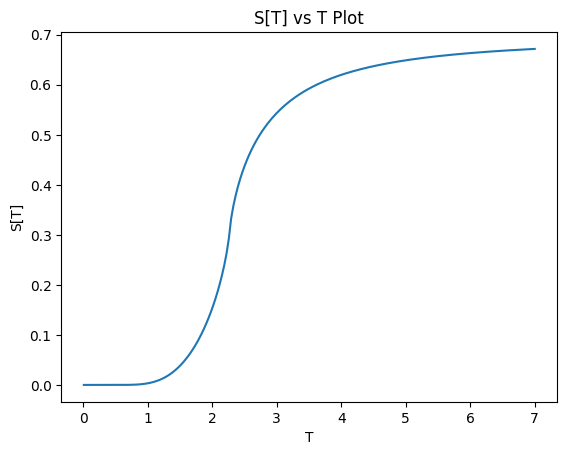

In [795]:
plt.plot(T_values, S_values_temp)

plt.xlabel("T")
plt.ylabel("S[T]")
plt.title("S[T] vs T Plot")

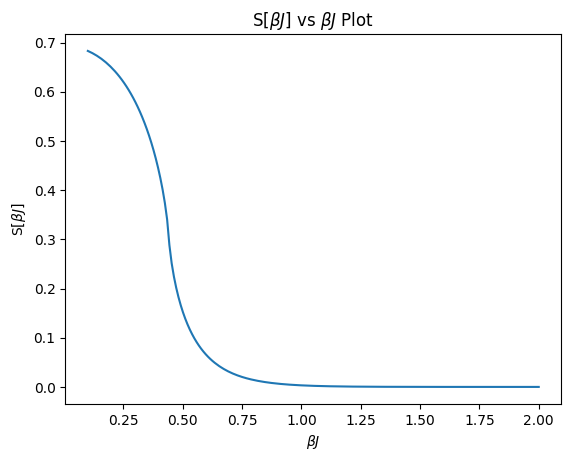

In [774]:

plt.plot(Beta_values, S_values_beta)
plt.xlabel(r"$\beta J$")
plt.ylabel(r"S[$\beta J$]")
plt.title(r"S[$\beta J$] vs $\beta J$ Plot")
plt.show()